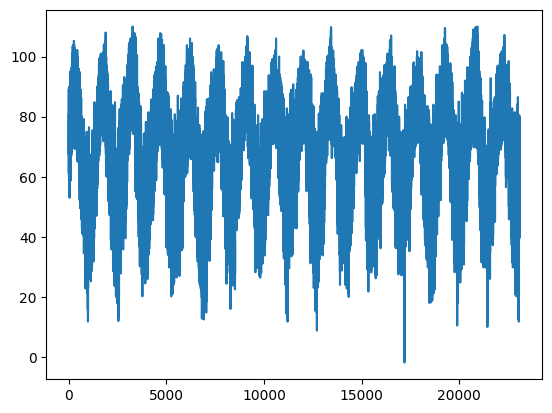

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(r"..\preprocessing\county_variables.csv")

plt.plot(data['Tarrant_temperature'])
plt.show()

In [14]:
import torch

data = torch.from_numpy(data.drop('Date', axis=1).values).float()

In [18]:
training_len = int(len(data) * 0.7)
test_len = len(data) - training_len
train, test = data[:training_len], data[training_len:]

In [24]:
train

tensor([[6.0000e+00, 6.7800e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         9.8000e+00],
        [1.2000e+01, 7.6800e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         9.8000e+00],
        [1.8000e+01, 8.4800e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         9.8000e+00],
        ...,
        [2.4000e+01, 7.8600e+01, 0.0000e+00,  ..., 2.0000e-02, 0.0000e+00,
         4.6000e+00],
        [6.0000e+00, 7.0200e+01, 0.0000e+00,  ..., 1.3800e-01, 0.0000e+00,
         5.4000e+00],
        [1.2000e+01, 8.0800e+01, 0.0000e+00,  ..., 1.3800e-01, 0.0000e+00,
         5.4000e+00]])

In [38]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.stack(X, dim=0), torch.stack(y, dim=0)

In [42]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self, io_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=io_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, io_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [44]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

lookback = 16
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = Model(len(train[0]), 60, 1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

C:\Users\Austin\AppData\Local\Temp\ipykernel_11824\2336783079.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\Austin\AppData\Local\Temp\ipykernel_11824\2336783079.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 7.9278, test RMSE 8.4048
Epoch 5: train RMSE 2.6696, test RMSE 3.6376
Epoch 10: train RMSE 2.4389, test RMSE 3.5240
Epoch 15: train RMSE 2.3255, test RMSE 3.3370
Epoch 20: train RMSE 2.2999, test RMSE 3.3356
Epoch 25: train RMSE 2.1784, test RMSE 3.2106
Epoch 30: train RMSE 2.2262, test RMSE 3.2491
Epoch 35: train RMSE 2.1051, test RMSE 3.2137
Epoch 40: train RMSE 2.1816, test RMSE 3.1798
Epoch 45: train RMSE 2.1195, test RMSE 3.2180


In [46]:
train[0]

tensor([ 6.0000, 67.8000,  0.0000,  0.0000,  9.5000, 70.5000,  0.0000,  0.0000,
        10.9000, 62.0000,  0.0000,  0.0000,  9.0000, 72.0000,  0.0000,  0.0000,
        11.5000, 68.5000,  0.0000,  0.0000,  9.6000, 73.0000,  0.0000,  0.0000,
         9.9000, 72.0000,  0.0000,  0.0000,  8.2000, 70.0000,  0.0000,  0.0000,
         9.4000, 70.5000,  0.0000,  0.0000,  9.8000, 64.0000,  0.0000,  0.0000,
         9.2000, 63.0000,  0.0000,  0.0000,  8.3000, 72.0000,  0.0000,  0.0000,
         6.9000, 69.0000,  0.0000,  0.0000,  7.9000, 74.0000,  0.0000,  0.0000,
         8.3000, 68.0000,  0.0000,  0.0000,  6.7000, 71.0000,  0.0000,  0.0000,
        10.0000, 72.0000,  0.0000,  0.0000, 10.3000, 64.0000,  0.0000,  0.0000,
         7.8000, 69.0000,  0.0000,  0.0000, 11.3000, 67.0000,  0.0000,  0.0000,
         9.1000, 73.0000,  0.0000,  0.0000,  8.6000, 73.0000,  0.0000,  0.0000,
         8.9000, 69.0000,  0.0000,  0.0000,  7.7000, 72.0000,  0.0000,  0.0000,
         9.8000, 68.7000,  0.0000,  0.00

In [100]:
previous = X_train[:1]
steps_forward = 28
forecast = []

def round_to_closest6(x):
    return min([6, 12, 18, 24], key=lambda xx: abs(x - xx))

#print(previous)

with torch.no_grad():
    for i in range(steps_forward):
        pred = model(previous)
        pred = pred[:,-1:,:]

        # correct for any error in the next predicted hour
        pred[-1, -1, 0] = round_to_closest6(pred[-1, -1, 0])
        
        #print(pred)
        forecast.append(pred[-1, -1, :])
        previous = torch.cat((previous[:, 1:, :], pred), dim=1)

print(forecast[0].numpy())
print(forecast[1].numpy())

[ 6.0000000e+00  5.9436230e+01  2.5507781e-01  2.4728782e-02
  6.0442939e+00  6.0031105e+01  7.2418123e-02  2.0146742e-03
  6.7954736e+00  5.4836678e+01  7.8649990e-02  2.0313710e-03
  4.0915313e+00  5.6647522e+01  3.3928633e-02 -2.4130754e-04
  5.7813745e+00  5.6772709e+01  6.8859018e-02 -1.6963240e-03
  4.7536941e+00  6.1114590e+01  2.4383625e-02  2.0339219e-03
  5.4914069e+00  5.8785110e+01  2.5817771e-02  6.7751762e-04
  5.4907594e+00  6.2154465e+01  4.4732999e-02 -3.0040741e-05
  6.4621482e+00  6.2132259e+01  1.0097522e-01  1.2024179e-02
  5.8644285e+00  5.6247372e+01  4.6764895e-02 -1.0006130e-05
  5.8758759e+00  5.6559444e+01  6.7912906e-02  4.5970082e-06
  4.9696851e+00  5.9355438e+01  4.6784848e-02  2.2088736e-04
  3.3250029e+00  5.4667294e+01  3.3668529e-02 -2.5845133e-04
  4.1131830e+00  5.8315250e+01  5.3089786e-02 -2.5524199e-04
  4.2554641e+00  5.8604694e+01  3.9682597e-02 -4.4919550e-05
  4.4303803e+00  5.9358944e+01  2.5546432e-02 -2.3730285e-04
  6.6287665e+00  6.07647

In [231]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import csv

class Model(nn.Module):
    def __init__(self, io_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=io_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, io_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.stack(X, dim=0), torch.stack(y, dim=0)

def train_model(obs_filepath, lookback, hidden_dim, epochs, train_pct):
    data = pd.read_csv(obs_filepath)

    data = torch.from_numpy(data.drop('Date', axis=1).values).float()
    training_len = int(len(data) * train_pct)
    test_len = len(data) - training_len
    train, test = data[:training_len], data[training_len:]
    
    X_train, y_train = create_dataset(train, lookback=lookback)
    X_test, y_test = create_dataset(test, lookback=lookback)
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)

    model = Model(len(train[0]), hidden_dim, 1)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = Data.DataLoader(Data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
     
    n_epochs = epochs
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 5 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Final model: train RMSE %.4f, test RMSE %.4f" % (train_rmse, test_rmse))

def generate_forecast(model, previous_observations, days_forward):
    steps_forward = 4 * days_forward
    previous = previous_observations

    hour = 6
    forecast = []
    with torch.no_grad():
        for i in range(steps_forward):
            pred = model(previous)
            pred = pred[-1:,:]
    
            # correct for any error in the next predicted hour
            pred[-1, 0] = hour
            if hour == 24:
                hour = 6
            else:
                hour += 6
            
            forecast.append(pred[-1, :])
            previous = torch.cat((previous[1:, :], pred), dim=0)
    
    return torch.stack(forecast, dim=0).numpy()

def fetch_previous_observations(obs_filepath, from_date, to_date):
    data = pd.read_csv(obs_filepath)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index(['Date', 'Hour'], inplace=True)
    data = data.loc[(from_date, 6):(to_date, 24)]
    data.reset_index(inplace=True)
    data.drop('Date', axis=1, inplace=True)
    data = torch.from_numpy(data.values).float()
    return data

In [217]:
import csv

def save_forecast(forecast_filepath, forecast, days_forecast, obs_filepath, first_date):
    with open(obs_filepath) as ff:
        reader = csv.reader(ff)
        cols = next(reader)
    
    df = pd.DataFrame(list(forecast), columns=cols[1:]).round(2)
    df[df < 0] = 0
    
    date = pd.to_datetime(first_date)
    dates = []
    for i in range(30):
        dates.extend([date, date, date, date])
        date += pd.Timedelta(days=1)
    
    df.insert(0, 'Date', pd.Series(dates))
    df.to_csv(forecast_filepath, index=False)

In [209]:
p = fetch_previous_observations(r"..\preprocessing\county_variables.csv", '2020-01-01', '2020-01-16')
f = generate_forecast(model, p, 30)
save_forecast(r"forecast.csv", f, 30, r"..\preprocessing\county_variables.csv", '2020-01-17')

In [ ]:
m2 = train_model(r"..\preprocessing\county_variables.csv", lookback=16, hidden_dim=70, epochs=40, train_pct=0.5)